In [63]:
import pandas as pd
import numpy as np
import joblib


# Modelado y evaluación
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import xgboost as xgb
from sklearn.feature_selection import SelectKBest, f_regression
from xgboost import XGBRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
!pip install catboost



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
df = pd.read_csv('../data/processed/df_sample_clean.csv')


In [4]:
df.head()

,airline,source_city,stops,destination_city,days_left,price_eur,departure_hour,class_Economy,duration_mins
0,Air_India,Delhi,1,Kolkata,40.0,72.89,9,1,1185
1,Vistara,Kolkata,1,Mumbai,42.0,641.57,9,0,589
2,Vistara,Kolkata,1,Bangalore,41.0,61.31,9,1,630
3,Vistara,Chennai,1,Delhi,14.0,595.34,22,0,870
4,Air_India,Bangalore,1,Mumbai,20.0,65.10,14,1,495


In [5]:
# Variable objetivo
y = df['price_eur']

# Variables predictoras (el resto)
X = df.drop(columns='price_eur')


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# Modelo 1: Random Forest Regressor con Pipeline y GridSearchCV


## Paso 1: Definir columnas categóricas y numéricas


In [7]:
categorical = ['airline', 'source_city', 'destination_city']
numerical = ['stops', 'duration_mins', 'days_left', 'departure_hour', 'class_Economy']


##  Paso 2: Crear el pipeline (preprocesador + modelo)


In [8]:
# Preprocesador
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first'), categorical),
    ('num', StandardScaler(), numerical)
])

# Pipeline completo
pipeline_rf = Pipeline([
    ('prep', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])


##  Paso 3: Definir hiperparámetros para GridSearchCV


In [9]:
param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [10, None],
    'model__min_samples_split': [2, 5]
}


##  Paso 4: Configurar y entrenar GridSearchCV


In [10]:
grid_rf = GridSearchCV(
    estimator=pipeline_rf,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

grid_rf.fit(X_train, y_train)


Fitting 3 folds for each of 8 candidates, totalling 24 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'model__max_depth': [10, None], 'model__min_samples_split': [2, 5], 'model__n_estimators': [100, 200]}"
,scoring,'neg_mean_absolute_error'
,n_jobs,-1
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('cat', ...), ('num', ...)]"


##  Paso 5: Evaluar el mejor modelo


In [11]:
# Mejor pipeline entrenado
best_rf = grid_rf.best_estimator_

# Predicciones sobre test
y_pred = best_rf.predict(X_test)

# Métricas
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Resultados
print(" Mejores hiperparámetros:", grid_rf.best_params_)
print(f" MAE:  {mae:.2f} €")
print(f" RMSE: {rmse:.2f} €")
print(f" R²:   {r2:.4f}")


 Mejores hiperparámetros: {'model__max_depth': None, 'model__min_samples_split': 2, 'model__n_estimators': 200}
 MAE:  16.53 €
 RMSE: 34.17 €
 R²:   0.9770


In [12]:
joblib.dump(best_rf, '../models/random_forest_model.pkl')


['../models/random_forest_model.pkl']

#  Modelo 2: CatBoostRegressor con GridSearchCV


##  Paso 1: Definir columnas categóricas (sin codificar)


In [13]:
# Estas columnas están en formato string y no necesitan codificarse
categorical_cols = ['airline', 'source_city', 'destination_city']


In [14]:
# Modelo base de CatBoost
catboost = CatBoostRegressor(
    verbose=0,        # Silenciar output durante el fit
    random_state=42
)

# Rejilla de parámetros para probar en GridSearch
param_grid = {
    'depth': [6, 8],
    'learning_rate': [0.05, 0.1],
    'iterations': [100, 200]
}

##  Paso 3: Configurar GridSearchCV y entrenar modelo

In [15]:
# GridSearch con validación cruzada
grid_catboost = GridSearchCV(
    estimator=catboost,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

# Entrenar (pasamos las columnas categóricas sin codificar)
grid_catboost.fit(X_train, y_train, cat_features=categorical_cols)


Fitting 3 folds for each of 8 candidates, totalling 24 fits


,estimator,<catboost.cor...002ABC7D26050>
,param_grid,"{'depth': [6, 8], 'iterations': [100, 200], 'learning_rate': [0.05, 0.1]}"
,scoring,'neg_mean_absolute_error'
,n_jobs,-1
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False


##  Paso 4: Evaluar el mejor modelo

In [16]:
# Seleccionar mejor modelo encontrado
best_catboost = grid_catboost.best_estimator_

# Predicción sobre test
y_pred_cat = best_catboost.predict(X_test)

# Métricas de evaluación
mae = mean_absolute_error(y_test, y_pred_cat)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_cat))  # evitamos error de 'squared'
r2 = r2_score(y_test, y_pred_cat)

# Resultados
print("Mejores hiperparámetros:", grid_catboost.best_params_)
print(f" MAE:  {mae:.2f} €")
print(f" RMSE: {rmse:.2f} €")
print(f" R²:   {r2:.4f}")


Mejores hiperparámetros: {'depth': 8, 'iterations': 200, 'learning_rate': 0.1}
 MAE:  23.75 €
 RMSE: 41.67 €
 R²:   0.9657


In [17]:
joblib.dump(best_catboost, '../models/catboost_model.pkl')


['../models/catboost_model.pkl']

In [18]:
y_pred_cat = best_catboost.predict(X_test)


c:\Users\Poltatil\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


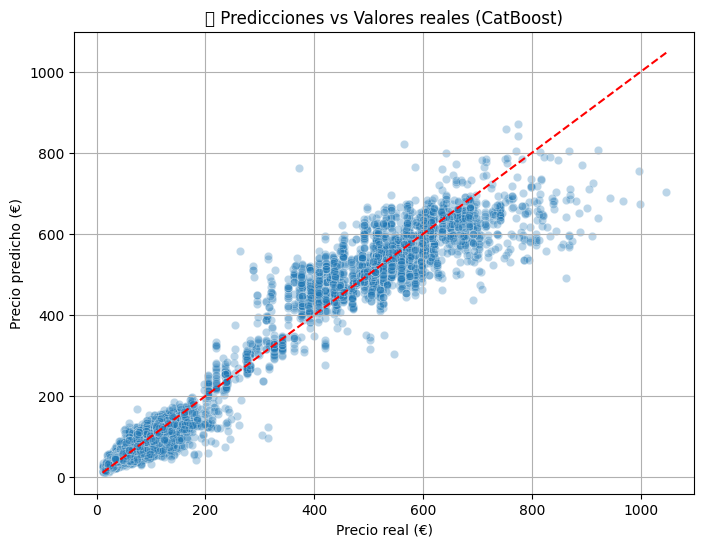

c:\Users\Poltatil\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


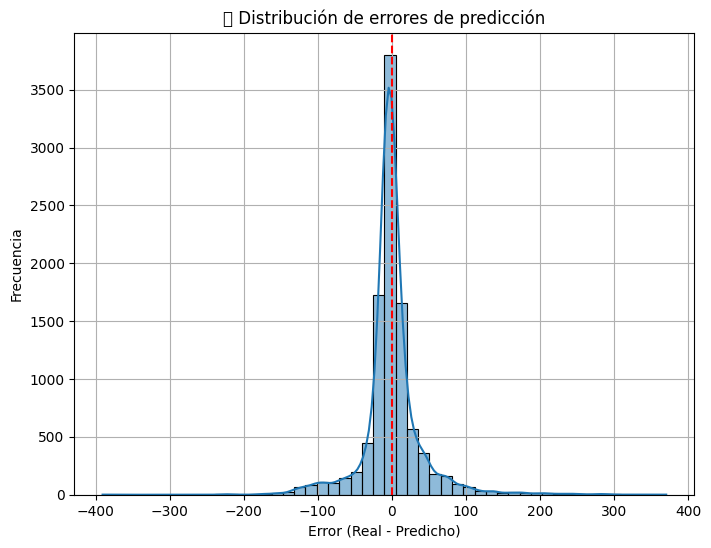

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Predicciones vs Reales
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_cat, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Precio real (€)")
plt.ylabel("Precio predicho (€)")
plt.title("📈 Predicciones vs Valores reales (CatBoost)")
plt.grid(True)
plt.show()

# 2. Distribución de errores (residuos)
errores = y_test - y_pred_cat

plt.figure(figsize=(8, 6))
sns.histplot(errores, bins=50, kde=True)
plt.axvline(0, color='red', linestyle='--')
plt.title("📉 Distribución de errores de predicción")
plt.xlabel("Error (Real - Predicho)")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.show()


#  Modelo 3: XGBoostRegressor con Pipeline y GridSearchCV


##  3. Crear preprocesador para variables categóricas


In [20]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical)
    ],
    remainder='passthrough'  # Deja pasar las columnas numéricas
)


## 4. Crear Pipeline completo (preprocesamiento + modelo)


In [21]:
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', XGBRegressor(objective='reg:squarederror', random_state=42))
])


##  6. Entrenar con GridSearchCV


In [22]:


param_grid = {
    'model__n_estimators': [100, 200],
    'model__learning_rate': [0.05, 0.1],
    'model__max_depth': [4, 6],
    'model__subsample': [0.8, 1.0],
    'model__colsample_bytree': [0.8, 1.0],
    'model__reg_lambda': [1, 1.5],
}



grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train, y_train)


Fitting 3 folds for each of 64 candidates, totalling 192 fits


,estimator,"Pipeline(step...=None, ...))])"
,param_grid,"{'model__colsample_bytree': [0.8, 1.0], 'model__learning_rate': [0.05, 0.1], 'model__max_depth': [4, 6], 'model__n_estimators': [100, 200], ...}"
,scoring,'neg_mean_absolute_error'
,n_jobs,-1
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('cat', ...)]"


##  7. Evaluar el mejor modelo


In [23]:
best_model = grid.best_estimator_

y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("  Mejores hiperparámetros:", grid.best_params_)
print(f" MAE:  {mae:.2f} €")
print(f" RMSE: {rmse:.2f} €")
print(f" R²:   {r2:.4f}")


  Mejores hiperparámetros: {'model__colsample_bytree': 1.0, 'model__learning_rate': 0.1, 'model__max_depth': 6, 'model__n_estimators': 200, 'model__reg_lambda': 1.5, 'model__subsample': 0.8}
 MAE:  22.41 €
 RMSE: 39.58 €
 R²:   0.9691


In [24]:
joblib.dump(best_model, '../models/xgboost_pipeline.pkl')


['../models/xgboost_pipeline.pkl']

#  Modelo 4: GradientBoostingRegressor con Pipeline y GridSearchCV


##  1. Definir columnas categóricas para codificar


In [25]:
cat_cols = ['airline', 'source_city', 'destination_city']


##  3. Crear preprocesador con OrdinalEncoder


In [26]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_cols)
    ],
    remainder='passthrough'
)


##  4. Crear pipeline con GradientBoostingRegressor

In [27]:
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', GradientBoostingRegressor(random_state=42))
])


##  5. Definir rejilla de hiperparámetros para GridSearchCV


In [28]:
param_grid = {
    'model__n_estimators': [100, 200],
    'model__learning_rate': [0.05, 0.1],
    'model__max_depth': [3, 5],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 3],
    'model__subsample': [0.8, 1.0]
}


## 6. Ejecutar GridSearchCV


In [29]:
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)


Fitting 3 folds for each of 64 candidates, totalling 192 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'model__learning_rate': [0.05, 0.1], 'model__max_depth': [3, 5], 'model__min_samples_leaf': [1, 3], 'model__min_samples_split': [2, 5], ...}"
,scoring,'neg_mean_absolute_error'
,n_jobs,-1
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('cat', ...)]"


##  7. Evaluar el mejor modelo


In [69]:
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(" Mejores hiperparámetros:", grid.best_params_)
print(f" MAE:  {mae:.2f} €")
print(f" RMSE: {rmse:.2f} €")
print(f" R²:   {r2:.4f}")


 Mejores hiperparámetros: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 200, 'model__subsample': 1.0}
 MAE:  28.59 €
 RMSE: 49.56 €
 R²:   0.9515


In [31]:
joblib.dump(best_model, '../models/gradient_boosting_ordenc.pkl')


['../models/gradient_boosting_ordenc.pkl']

#  Comparativa: OneHotEncoder vs OrdinalEncoder en GradientBoostingRegressor


In [32]:
# OneHotEncoder
preprocessor_ohe = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
    remainder='passthrough'
)

In [33]:
pipeline_ohe = Pipeline([
    ('preprocessing', preprocessor_ohe),
    ('model', GradientBoostingRegressor(random_state=42))
])


In [34]:
# OneHotEncoder
grid_ohe = GridSearchCV(
    estimator=pipeline_ohe,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)
grid_ohe.fit(X_train, y_train)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'model__learning_rate': [0.05, 0.1], 'model__max_depth': [3, 5], 'model__min_samples_leaf': [1, 3], 'model__min_samples_split': [2, 5], ...}"
,scoring,'neg_mean_absolute_error'
,n_jobs,-1
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('cat', ...)]"


In [35]:
# OneHotEncoder
best_ohe = grid_ohe.best_estimator_
y_pred_ohe = best_ohe.predict(X_test)

mae_ohe = mean_absolute_error(y_test, y_pred_ohe)
rmse_ohe = np.sqrt(mean_squared_error(y_test, y_pred_ohe))
r2_ohe = r2_score(y_test, y_pred_ohe)

In [70]:
print(" Mejores hiperparámetros (OneHotEncoder):", grid_ohe.best_params_)
print(f" MAE:  {mae_ohe:.2f} €")
print(f" RMSE: {rmse_ohe:.2f} €")
print(f" R²:   {r2_ohe:.4f}")

 Mejores hiperparámetros (OneHotEncoder): {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 200, 'model__subsample': 0.8}
 MAE:  24.16 €
 RMSE: 41.72 €
 R²:   0.9656


#  Modelo 5: XGBoost Regressor con OneHotEncoder y GridSearchCV (cv=5)


##  Paso 3: Crear el pipeline con OneHotEncoder + XGBoost


In [37]:
# Preprocesamiento
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ],
    remainder='passthrough'
)

# Pipeline
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1))
])


##  Paso 4: Definir la rejilla de hiperparámetros (param_grid)


In [38]:
param_grid = {
    'model__n_estimators': [100, 150],
    'model__learning_rate': [0.05, 0.1],
    'model__max_depth': [4, 6],
    'model__subsample': [0.8, 1.0],
    'model__colsample_bytree': [0.8, 1.0]
}


##  Paso 5: Entrenar con GridSearchCV (cv=5)


In [39]:
grid_xgb = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

grid_xgb.fit(X_train, y_train)


Fitting 5 folds for each of 32 candidates, totalling 160 fits


,estimator,"Pipeline(step...=None, ...))])"
,param_grid,"{'model__colsample_bytree': [0.8, 1.0], 'model__learning_rate': [0.05, 0.1], 'model__max_depth': [4, 6], 'model__n_estimators': [100, 150], ...}"
,scoring,'neg_mean_absolute_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('cat', ...)]"


##  Paso 6: Evaluar el modelo



In [71]:
best_xgb = grid_xgb.best_estimator_
y_pred = best_xgb.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(" Mejores hiperparámetros:", grid_xgb.best_params_)
print(f" MAE:  {mae:.2f} €")
print(f" RMSE: {rmse:.2f} €")
print(f" R²:   {r2:.4f}")


 Mejores hiperparámetros: {'model__colsample_bytree': 1.0, 'model__learning_rate': 0.1, 'model__max_depth': 6, 'model__n_estimators': 150, 'model__subsample': 0.8}
 MAE:  23.23 €
 RMSE: 40.70 €
 R²:   0.9673


In [41]:
joblib.dump(best_xgb, '../models/xgboost_model.pkl')


['../models/xgboost_model.pkl']

#  Modelo No Supervisado: KMeans Clustering

Vamos a aplicar un modelo no supervisado de tipo `KMeans` para agrupar los vuelos en diferentes clústers según sus características numéricas.

Este modelo puede servir para:

- Detectar patrones entre vuelos
- Agrupar vuelos similares
- Añadir una nueva variable categórica (`cluster`) a los modelos supervisados


## 🔍 Paso 2: Seleccionar variables numéricas para clustering


In [42]:
features_cluster = [
    'duration_mins', 
    'days_left', 
    'price_eur', 
    'departure_hour', 
    'stops', 
    'class_Economy'
]

X_cluster = df[features_cluster]


##  Paso 3: Escalar las variables
Usamos StandardScaler para normalizar todas las columnas numéricas.


In [43]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)


##  Paso 4: Elegir el número óptimo de clústers (Método del codo)
Calculamos la inercia para diferentes valores de k (de 1 a 9) y la representamos gráficamente.


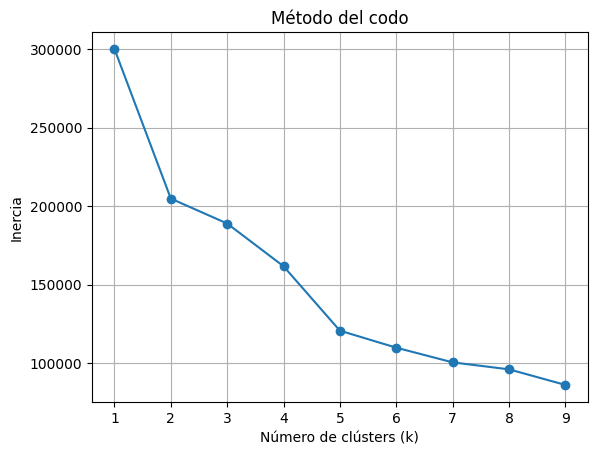

In [74]:
inertia = []
k_range = range(1, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(k_range, inertia, marker='o')
plt.xlabel('Número de clústers (k)')
plt.ylabel('Inercia')
plt.title('Método del codo')
plt.grid(True)
plt.show()


##  Paso 5: Aplicar KMeans con el número óptimo de clústers


In [45]:
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

df['cluster'] = clusters


##  Paso 6: Visualización en 2D con PCA
Reducimos las dimensiones a 2 componentes principales para poder visualizar los clústers.


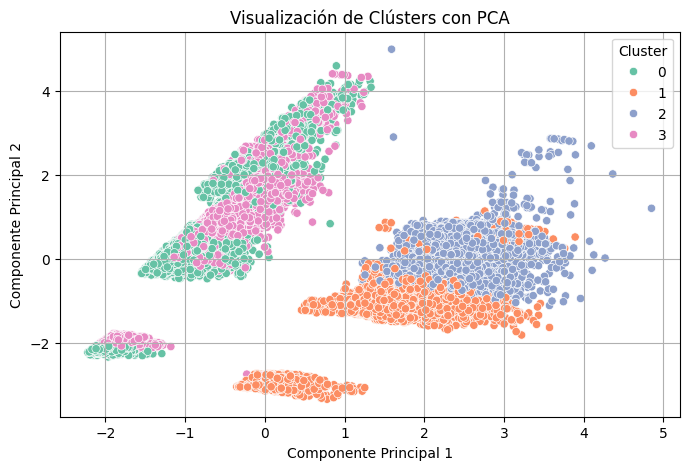

In [46]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters, palette='Set2')
plt.title('Visualización de Clústers con PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


In [47]:
df.groupby('cluster')[features_cluster].mean().round(2)


,duration_mins,days_left,price_eur,departure_hour,stops,class_Economy
cluster,,,,,,
0,629.21,26.98,65.19,8.42,0.98,1.0
1,558.09,26.17,507.03,9.69,0.86,0.0
2,1150.67,25.40,534.24,18.01,1.01,0.0
3,764.20,25.06,64.42,18.48,0.86,1.0


In [48]:
df.head()

,airline,source_city,stops,destination_city,days_left,price_eur,departure_hour,class_Economy,duration_mins,cluster
0,Air_India,Delhi,1,Kolkata,40.0,72.89,9,1,1185,0
1,Vistara,Kolkata,1,Mumbai,42.0,641.57,9,0,589,1
2,Vistara,Kolkata,1,Bangalore,41.0,61.31,9,1,630,0
3,Vistara,Chennai,1,Delhi,14.0,595.34,22,0,870,2
4,Air_India,Bangalore,1,Mumbai,20.0,65.10,14,1,495,3


#  Clustering con DBSCAN (Modelo No Supervisado)


##  Paso 2: Seleccionar variables numéricas para clustering


In [49]:
features_cluster = [
    'duration_mins', 
    'days_left', 
    'price_eur', 
    'departure_hour', 
    'stops', 
    'class_Economy'
]

X_cluster = df[features_cluster]


##  Paso 3: Escalar las variables con StandardScaler


In [50]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

##  Paso 4: Aplicar DBSCAN
Elegimos los parámetros `eps` (radio) y `min_samples` (mínimo puntos por vecindad).


In [72]:
dbscan = DBSCAN(eps=1.5, min_samples=10) 
clusters_dbscan = dbscan.fit_predict(X_scaled)

df['cluster_dbscan'] = clusters_dbscan


##  Paso 5: Visualizar los clústers con PCA
Usamos PCA para reducir a 2 dimensiones.


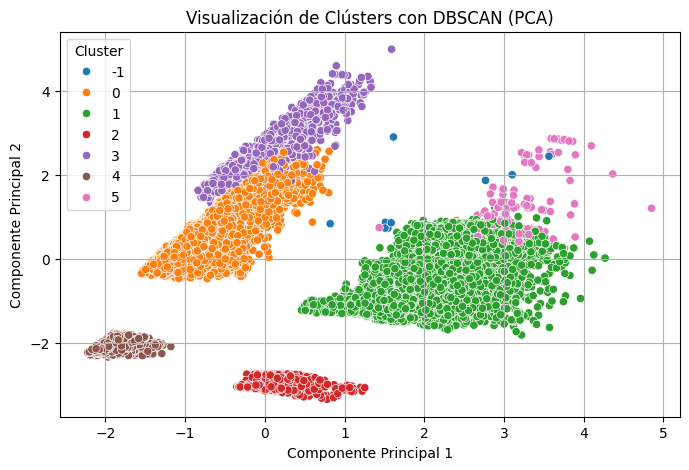

In [52]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 5))
sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=clusters_dbscan,
    palette='tab10',
    legend='full'
)
plt.title('Visualización de Clústers con DBSCAN (PCA)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


## Paso 6: Análisis de los clústers

El clúster `-1` representa los **outliers** que DBSCAN ha considerado "ruido".

In [53]:
df['cluster_dbscan'].value_counts()

df.groupby('cluster_dbscan')[features_cluster].mean().round(2)

,duration_mins,days_left,price_eur,departure_hour,stops,class_Economy
cluster_dbscan,,,,,,
-1,1170.44,28.11,359.38,11.22,1.78,0.11
0,767.99,26.27,67.08,13.07,1.00,1.00
1,892.99,25.84,539.83,13.52,1.00,0.00
2,136.39,25.70,276.31,13.76,0.00,0.00
3,919.22,25.08,90.55,11.29,2.00,1.00
4,129.63,25.56,39.90,13.47,0.00,1.00
5,922.98,24.47,690.88,12.13,2.00,0.00


In [54]:
df.head()

,airline,source_city,stops,destination_city,days_left,price_eur,departure_hour,class_Economy,duration_mins,cluster,cluster_dbscan
0,Air_India,Delhi,1,Kolkata,40.0,72.89,9,1,1185,0,0
1,Vistara,Kolkata,1,Mumbai,42.0,641.57,9,0,589,1,1
2,Vistara,Kolkata,1,Bangalore,41.0,61.31,9,1,630,0,0
3,Vistara,Chennai,1,Delhi,14.0,595.34,22,0,870,2,1
4,Air_India,Bangalore,1,Mumbai,20.0,65.10,14,1,495,3,0


In [55]:
# Guardar los modelos no sipervisados
joblib.dump(kmeans, "../models/kmeans_model.pkl")
joblib.dump(dbscan, "../models/dbscan_model.pkl")

['../models/dbscan_model.pkl']

#  Modelo 5: XGBoost con Pipeline Avanzado y Variables de Clustering


###  Detección de variables numéricas y categóricas


In [56]:
cat_features = X.select_dtypes(include='object').columns.tolist()
num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()


###  Preprocesamiento de columnas
- Las numéricas se escalan y se imputan
- Las categóricas se codifican con OneHotEncoder


In [ ]:
preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),  
        ('scaler', StandardScaler())
    ]), num_features),
    
    ('cat', Pipeline([
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]), cat_features)
])


###  Definición del pipeline completo


In [64]:
pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('feature_selection', SelectKBest(score_func=f_regression, k=12)),
    ('model', xgb.XGBRegressor(objective='reg:squarederror', random_state=42))
])


###  Definición del espacio de búsqueda para GridSearchCV


In [65]:
param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [3, 5],
    'model__learning_rate': [0.05, 0.1],
    'model__subsample': [0.8, 1.0]
}


###  División en train/test y entrenamiento con GridSearchCV


In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
grid.fit(X_train, y_train)


,estimator,"Pipeline(step...=None, ...))])"
,param_grid,"{'model__learning_rate': [0.05, 0.1], 'model__max_depth': [3, 5], 'model__n_estimators': [100, 200], 'model__subsample': [0.8, 1.0]}"
,scoring,'neg_mean_absolute_error'
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


###  Evaluación del modelo final


In [73]:
y_pred = grid.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(" Mejores hiperparámetros:", grid.best_params_)
print(f" MAE:  {mae:.2f} €")
print(f" RMSE: {rmse:.2f} €")
print(f"R²:   {r2:.4f}")


 Mejores hiperparámetros: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 200, 'model__subsample': 1.0}
 MAE:  28.59 €
 RMSE: 49.56 €
R²:   0.9515


In [68]:
# Guardar el modelo entrenado
joblib.dump(grid.best_estimator_, "../models/modelo_5_xgboost.pkl")

['../models/modelo_5_xgboost.pkl']